## Import & Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
url = 'https://drive.google.com/uc?id=15wrKKNpft9M2Pxcq_ouXP_VdL1rliVzn'

df = pd.read_csv(url)

In [ ]:
df.head()

,invoice_date,total_transaction,total_quantity,total_sales,day_of_week,month,is_weekend
0,2009-12-01,154,20736,45958.31,1,12,0
1,2009-12-02,125,25657,54826.26,2,12,0
2,2009-12-03,144,44557,57521.87,3,12,0
3,2009-12-04,100,19550,37222.23,4,12,0
4,2009-12-05,31,4636,8803.86,5,12,1


In [ ]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [ ]:
df['date_ordinal'] = df['invoice_date'].map(pd.Timestamp.toordinal)
df = df.sort_values('date_ordinal').reset_index(drop=True)

In [ ]:
df.head()

,invoice_date,total_transaction,total_quantity,total_sales,day_of_week,month,is_weekend,date_ordinal
0,2009-12-01,154,20736,45958.31,1,12,0,733742
1,2009-12-02,125,25657,54826.26,2,12,0,733743
2,2009-12-03,144,44557,57521.87,3,12,0,733744
3,2009-12-04,100,19550,37222.23,4,12,0,733745
4,2009-12-05,31,4636,8803.86,5,12,1,733746


In [ ]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

In [ ]:
df.set_index('invoice_date', inplace=True)

In [ ]:
# Chronological train-test split (80/20)
cutoff_date = df.index.max() - pd.Timedelta(days=30)

# Split into train and test sets
train_df = df[df.index <= cutoff_date]
test_df = df[df.index > cutoff_date]

#### Helpers to remove redundant coding

In [ ]:
# Helper Function to fit and predict the values

def train_and_predict(model, train_df, test_df):
    features = ['date_ordinal', 'day_of_week', 'month', 'is_weekend']

    X_train = train_df[features].values
    y_train = train_df['total_quantity'].values

    X_test = test_df[features].values
    model.fit(X_train, y_train)

    return model.predict(X_test)


In [ ]:
# Helper Functions to plot the chart

def plot_actual_vs_predicted(train_df, test_df, pred_lr):
    # Combine last 60 days of train with test data
    combined_df = pd.concat([train_df.iloc[-60:], test_df])

    plt.figure(figsize=(12, 6))

    # Plot actual values (train + test)
    plt.plot(combined_df.index, combined_df['total_quantity'],
             label='Actual Quantity', color='blue', linewidth=2)

    # Plot predicted values (only for test set)
    plt.plot(test_df.index, pred_lr,
             label='Predicted Quantity', color='red', linestyle='--', linewidth=2)

    # Add vertical line to mark test set start
    plt.axvline(x=test_df.index.min(), color='gray', linestyle=':',
                label='Test Set Start')

    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.title('Actual vs Predicted Sales with 30 Days Prior Data')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


## Machine Learning Models

### Linear Regression

Linear regression can be applied to time series forecasting by modeling the relationship between time and the target variable. However, its performance is limited in our data as it exhibits non-linear patterns.

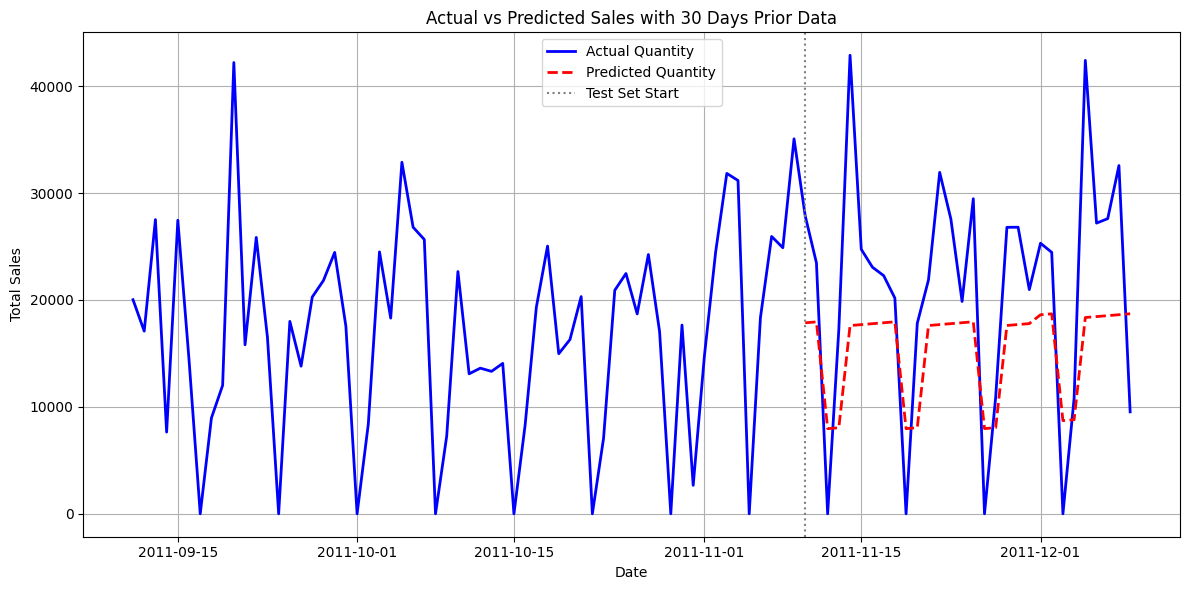

In [ ]:
lr = LinearRegression()
pred_lr = train_and_predict(lr, train_df, test_df)

# Call the function with the train, test data and predictions
plot_actual_vs_predicted(train_df, test_df, pred_lr)

### Random Forest

Random Forest Regressor can be applied to time series forecasting by modeling complex relationships between time (and other features) and the target variable. It excels at capturing non-linear patterns and interactions, offering improved performance over linear regression in many cases.

In this case, there is significant overprediction in some areas because the model relies heavily on patterns observed in the previous data. To improve accuracy, we need more years of data for the model to learn and generalize better.

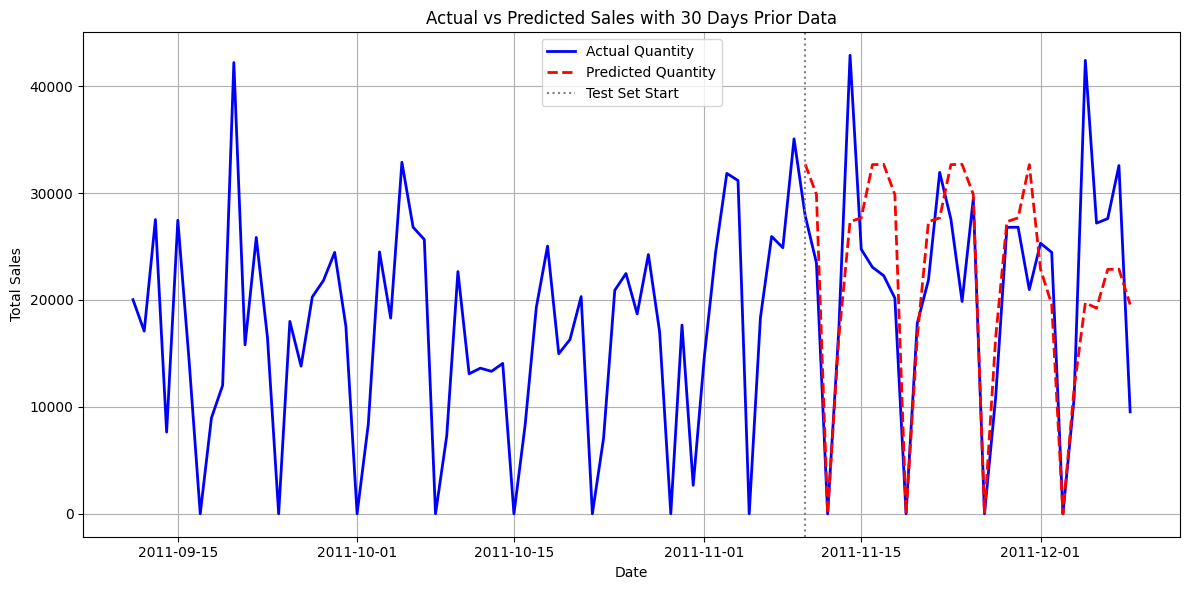

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
pred_rf = train_and_predict(rf, train_df, test_df)

plot_actual_vs_predicted(train_df, test_df, pred_rf)

### XGBoost

XGBoost (Extreme Gradient Boosting) is a scalable, efficient implementation of gradient boosting for supervised learning tasks (regression, classification). It builds an additive model in a forward stage-wise manner by minimizing an objective function that combines a loss function and a regularization term.

#### Mathematical Foundations of XGBoost

XGBoost (Extreme Gradient Boosting) is an optimized gradient boosting algorithm. Below is the mathematical framework behind it, presented with LaTeX equations for clarity.

#### 1. Objective Function

The goal of XGBoost is to minimize an objective function that balances model accuracy and complexity:

$$
\text{Obj} = \sum_{i=1}^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)
$$

where:
- $l(y_i, \hat{y}_i)$: Loss function measuring the difference between the true label $y_i$ and the predicted value $\hat{y}_i$ for the $i$-th data point.
- $\Omega(f_k)$: Regularization term for the $k$-th tree to prevent overfitting.
- $n$: Number of data points.
- $K$: Number of trees.

**Common Loss Functions**:
- **Regression (Mean Squared Error)**: $l(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2$
- **Classification (Log Loss)**: $l(y_i, \hat{y}_i) = -[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$

The regularization term is:

$$
\Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^T w_j^2
$$

where:
- $T$: Number of leaves in the tree.
- $\gamma$: Penalty for each leaf (controls tree complexity).
- $\lambda$: L2 regularization parameter on leaf weights.
- $w_j$: Weight (output) of the $j$-th leaf.

#### 2. Additive Training

XGBoost builds trees sequentially, where each tree corrects the errors of the previous ones. The prediction at iteration $t$ for the $i$-th data point is:

$$
\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta f_t(x_i)
$$

where:
- $\hat{y}_i^{(t-1)}$: Prediction from the previous iteration.
- $f_t(x_i)$: Output of the $t$-th tree for input $x_i$.
- $\eta$: Learning rate (shrinkage parameter).

The final prediction after $K$ trees is:

$$
\hat{y}_i = \sum_{k=1}^K f_k(x_i)
$$

#### 3. Optimization via Second-Order Taylor Approximation

At iteration $t$, the objective function for the new tree $f_t$ is approximated using a second-order Taylor expansion:

$$
\text{Obj}^{(t)} \approx \sum_{i=1}^n \left[ l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t(x_i)^2 \right] + \Omega(f_t)
$$

where:
- $g_i = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}}$: First-order gradient.
- $h_i = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial (\hat{y}_i^{(t-1)})^2}$: Second-order gradient (Hessian).

**Example Gradients and Hessians**:
- **MSE (Regression)**: $g_i = 2(\hat{y}_i^{(t-1)} - y_i)$, $h_i = 2$
- **Log Loss (Classification)**: $g_i = \hat{y}_i^{(t-1)} - y_i$, $h_i = \hat{y}_i^{(t-1)} (1 - \hat{y}_i^{(t-1)})$

The constant term $l(y_i, \hat{y}_i^{(t-1)})$ is dropped as it does not affect optimization.

#### 4. Tree Structure and Scoring

Each tree assigns data points to leaves, and the prediction $f_t(x_i)$ is the weight $w_j$ of the leaf to which $x_i$ is assigned. The objective function is rewritten as:

$$
\text{Obj}^{(t)} = \sum_{j=1}^T \left[ \left( \sum_{i \in I_j} g_i \right) w_j + \frac{1}{2} \left( \sum_{i \in I_j} h_i + \lambda \right) w_j^2 \right] + \gamma T
$$

where $I_j$ is the set of data points in the $j$-th leaf. The optimal leaf weight $w_j^*$ is:

$$
w_j^* = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

The corresponding objective value for the leaf is:

$$
\text{Obj}_j = -\frac{1}{2} \frac{\left( \sum_{i \in I_j} g_i \right)^2}{\sum_{i \in I_j} h_i + \lambda} + \gamma
$$

#### 5. Splitting Criteria

Splits are chosen to maximize the gain in the objective function:

$$
\text{Gain} = \frac{1}{2} \left[ \frac{\left( \sum_{i \in I_L} g_i \right)^2}{\sum_{i \in I_L} h_i + \lambda} + \frac{\left( \sum_{i \in I_R} g_i \right)^2}{\sum_{i \in I_R} h_i + \lambda} - \frac{\left( \sum_{i \in I} g_i \right)^2}{\sum_{i \in I} h_i + \lambda} \right] - \gamma
$$

where:
- $I_L$, $I_R$: Sets of data points in the left and right child nodes.
- $I$: Set of data points in the parent node.

#### 6. Handling Missing Values

Missing values are assigned to the branch (left or right) that minimizes the loss during training, based on the gain.

#### 7. Additional Optimizations

XGBoost includes optimizations such as:
- **Weighted Quantile Sketch**: For efficient split point selection.
- **Sparsity-Aware Split Finding**: Optimizes for sparse data.
- **Parallelization**: Split finding across features.
- **Subsampling**: Row and column subsampling.

This framework, combined with engineering optimizations, makes XGBoost highly effective for supervised learning tasks.


**XGBRegressor Implementation**

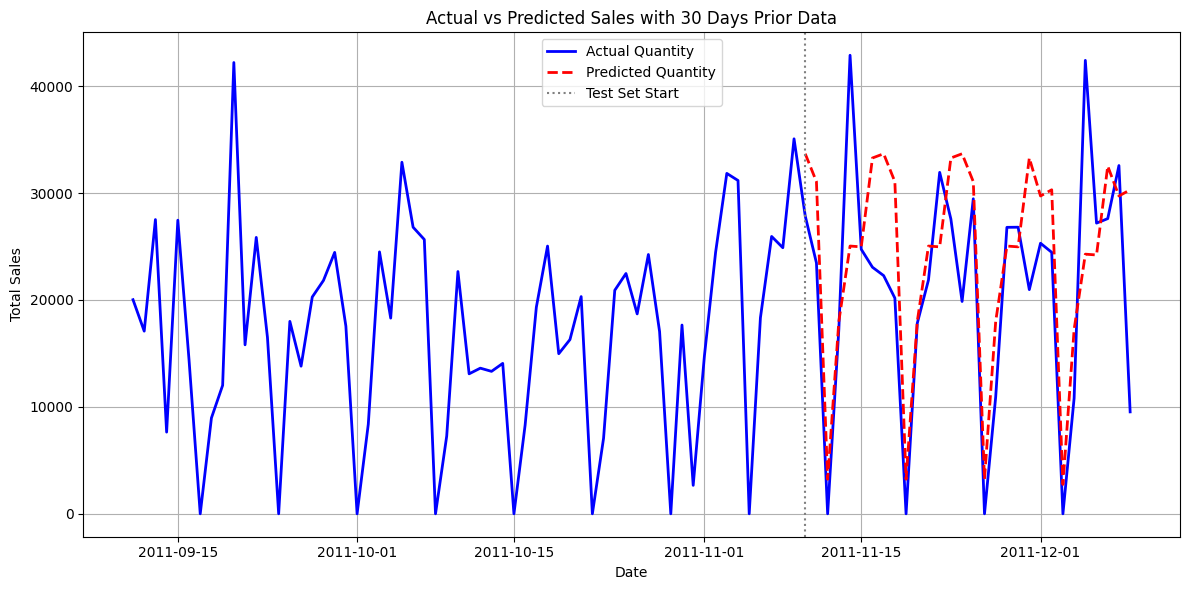

In [ ]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
pred_xgb = train_and_predict(xgb, train_df, test_df)

plot_actual_vs_predicted(train_df, test_df, pred_xgb)

In this case, XGBoost delivers slightly better accuracy compared to other models. However, like many models, it requires sufficient historical data to learn meaningful patterns and improve its ability to generalize.

## Hybrid and Ensemble Models

Ensemble models combine multiple individual forecasting models to improve accuracy and robustness. Instead of relying on a single model, ensembles leverage the strengths of different models and reduce the risk of overfitting or bias.

Why Use Ensembles?

* **Improve accuracy:** Combining predictions often yields better results than any single model.

* **Reduce variance:** Different models make different errors, so averaging smooths out noise.

* **Capture diverse patterns:** Some models are better at trend, others at seasonality, etc.

* **Robustness:** Ensemble reduces risk from model misspecification or data anomalies.



### Methodology

#### 1. **Simple Averaging**

* Take the average (mean or median) of predictions from different models.
* Easy to implement and often effective.

#### 2. **Weighted Averaging**

* Assign weights to models based on past performance or domain knowledge.
* Weights can be static or adaptive over time.

#### 3. **Stacking (Stacked Generalization)**

* Train a "meta-model" to learn how to combine base model predictions.
* The meta-model learns optimal weights and relationships.

#### 4. **Boosting**

* Sequentially train models where each new model focuses on errors of previous ones.
* Examples: Gradient Boosting Machines (GBM), XGBoost, LightGBM.
* Mostly used for regression but adaptable for forecasting.

#### 5. **Bagging (Bootstrap Aggregating)**

* Train multiple models on random subsets of data.
* Aggregate predictions, often via averaging.
* Example: Random Forest Regressor.

#### 6. **Hybrid Models**

* Combine different model types, e.g., statistical + machine learning + deep learning.
* Example: ARIMA + LSTM + Prophet ensemble.




### Ensemble Model (ARIMA & XGBoost) - Classical & ML Model

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

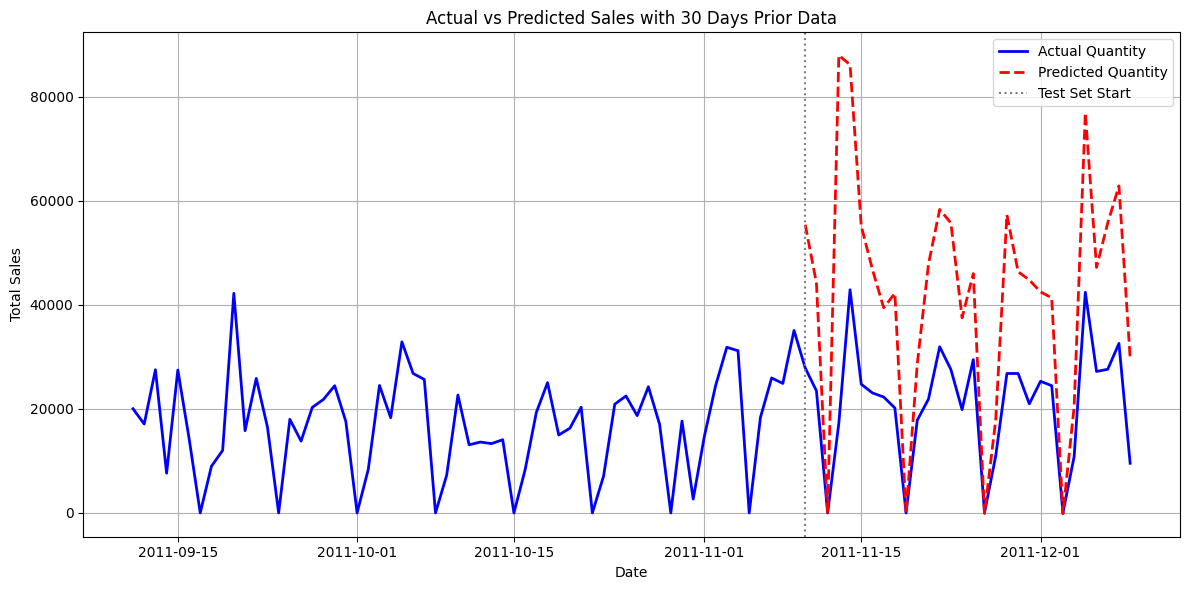

In [ ]:
# Helper function to train ARIMA and get predictions
def get_arima_predictions(train_series, test_len):
    # Fit ARIMA model (order can be tuned; using (1,1,1) as a simple example)
    model = ARIMA(train_series, order=(1, 1, 1))
    model_fit = model.fit()
    # Forecast for the test set length
    forecast = model_fit.forecast(steps=test_len)
    return forecast

# Helper function for training and predicting with hybrid model
def train_and_predict_hybrid(train_df, test_df):
    features = ['date_ordinal', 'total_transaction', 'total_quantity', 'day_of_week', 'month', 'is_weekend']

    # Get ARIMA predictions for training and test sets
    train_arima_pred = get_arima_predictions(train_df['total_sales'], len(train_df))
    test_arima_pred = get_arima_predictions(train_df['total_sales'], len(test_df))

    # Add ARIMA predictions as a feature
    train_df['arima_pred'] = train_arima_pred
    test_df['arima_pred'] = test_arima_pred

    # Prepare feature matrices
    X_train = train_df[features + ['arima_pred']].values
    y_train = train_df['total_sales'].values
    X_test = test_df[features + ['arima_pred']].values

    # Train Random Forest model
    xgb = XGBRegressor(n_estimators=100, random_state=42)
    xgb.fit(X_train, y_train)

    # Predict
    return xgb.predict(X_test)


# Train and predict with hybrid model
pred_hybrid = train_and_predict_hybrid(train_df, test_df)

# Plot results
plot_actual_vs_predicted(train_df, test_df, pred_hybrid)

#### **Step-by-Step Breakdown of the above Ensemble Model**

1. **ARIMA Forecasting for Baseline Trend**

   * The `get_arima_predictions()` function fits an ARIMA(1,1,1) model on the `total_sales` column of the training data.
   * It forecasts both:

     * the length of the training set (for feature creation),
     * and the length of the test set (to use in test features).

2. **Add ARIMA Predictions as a Feature**

   * The ARIMA predictions are added as a new column (`arima_pred`) to both `train_df` and `test_df`.
   * This allows the Random Forest (XGBoost) model to use ARIMA’s trend component as an input.

3. **Feature Preparation**

   * Features used: time-based and sales-related (`date_ordinal`, `total_transaction`, `total_quantity`, `day_of_week`, `month`, `is_weekend`, and `arima_pred`).
   * Constructs training and testing feature matrices (`X_train`, `X_test`) and target vector `y_train`.

4. **Train XGBoost Model**

   * An `XGBRegressor` is trained on `X_train` to learn patterns including ARIMA’s forecast as context.

5. **Predict on Test Set**

   * The trained XGBoost model predicts `total_sales` for the test set using all features including ARIMA’s forecast.


## Deep Learning Models


Deep Leaning Models will be covered in the future topics here is basic and how they work just for reference, will learn more about them indepth in upcoming sessions.


### 1. **MLP (Multilayer Perceptron)**


A fully connected feedforward neural network that maps input features to output using layers of neurons.

**How it works (in time series):**

* Takes **lagged values or engineered features** as input.
* Learns **nonlinear relationships** between input and target.
* Cannot capture temporal order unless explicitly encoded.


### 2. **RNN (Recurrent Neural Network)**


A neural network designed for sequential data where **outputs depend on previous time steps**.

**How it works:**

* Maintains a **hidden state** that’s updated at each time step.
* Can model **short-term dependencies** in sequences.
* Struggles with long-term memory due to vanishing gradients.


### 3.  **LSTM (Long Short-Term Memory)**


A special type of RNN that uses **gates** to manage long-term and short-term memory.

**How it works:**

* Contains **input, forget, and output gates** to regulate information flow.
* Effectively models **long-term dependencies** in time series.
* Commonly used for **multi-step forecasting** and complex temporal patterns.


### 4. **Temporal CNN (Temporal Convolutional Network, TCN)**


A convolutional model adapted for sequential data using **causal and dilated convolutions**.

**How it works:**

* Applies 1D convolutions over time with **causal padding** (future data is not leaked).
* **Dilated convolutions** allow long-range temporal dependencies.
* Faster training than RNNs and LSTMs, with **parallelism and stable gradients**.



### 5. **Transformer-based Models**


Models that use **self-attention mechanisms** to learn dependencies across all time steps.

**How it works:**

* **No recurrence**; processes the entire sequence at once.
* Uses **positional encodings** to retain time information.
* Learns **global temporal patterns** and handles **long sequences** efficiently.
* Examples: **Informer, Time Series Transformer, Temporal Fusion Transformer (TFT)**
